## <center style="color:blue;">**SparkAttriNet**</center>

Dans le secteur bancaire, anticiper la perte de clients est essentiel pour réduire le taux d’attrition et renforcer la fidélisation. 

Ce projet exploite la puissance de PySpark pour analyser de grands volumes de données, MLlib pour entraîner un modèle prédictif, MongoDB pour stocker les données transformées, et Streamlit pour visualiser les résultats et faciliter la prise de décision.

<br>

### <span style="color:green;">**Configuration et Initialisation du Pipeline Spark :**</span>

#### <span style="color:orange;">**1. Apache Spark :**</span>

##### **1.1. Définition :**

``Apache Spark`` est un framework open-source conçu pour le traitement distribué de données à grande échelle.
Il permet d’exécuter des calculs complexes sur des volumes massifs de données en les répartissant sur plusieurs machines d’un cluster.

``Spark`` fonctionne en mémoire (in-memory computing), ce qui le rend beaucoup plus rapide que les systèmes traditionnels comme Hadoop MapReduce.

##### **1.2. A quoi sert ?**

``Spark`` sert principalement à analyser, transformer et traiter de grandes quantités de données de manière efficace et parallèle.
Il est utilisé pour des tâches variées :

- **Traitement de données massives (Big Data) :** nettoyage, agrégation, transformation de fichiers volumineux.

- **Analyse exploratoire et statistique** à grande échelle.

- **Machine Learning** via la bibliothèque intégrée ``MLlib``, pour entraîner des modèles sur d’énormes datasets.

- **Traitement de flux en temps réel** (avec ``Spark Streaming``) pour suivre des événements en continu.

En résumé, ``Spark`` est une plateforme unifiée qui permet de manipuler, analyser et modéliser des données massives, tout en offrant des performances élevées grâce à son exécution distribuée.

#### <span style="color:orange;">**2. Créer une session Spark optimisée :**</span>

La ``SparkSession`` est le point d’entrée principal pour interagir avec ``Spark``.

C’est le cerveau de chaque application ``Spark`` :

elle permet de créer des DataFrames, d’exécuter des requêtes SQL, de lire et écrire des fichiers (CSV, Parquet, JSON, etc.), et de configurer un cluster.

```js
spark = (
    SparkSession.builder
        .appName("AttriSpark - Client Attrition Prediction")
        .master("local[14]")
        .config("spark.driver.memory", "24g")
        .config("spark.executor.memory", "24g")
        .config("spark.sql.shuffle.partitions", "32")
        .config("spark.memory.fraction", "0.7")
        .config("spark.memory.storageFraction", "0.5")
        .config("spark.sql.adaptive.enabled", "true")
        .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer")
        .config("spark.sql.execution.arrow.pyspark.enabled", "true")
        .getOrCreate()
)
```

In [2]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .appName("SparkAttriNet - Prédiction de l'Attrition Client Bancaire") \
    .config("spark.executor.memory", "4g") \
    .getOrCreate()

#### <span style="color:orange;">**3. Vérifier la version de Spark. :**</span>

In [3]:
print("Spark Session Créée avec Succès !")
print(f"Version Spark : {spark.version}")

Spark Session Créée avec Succès !
Version Spark : 4.0.1


<br>

### <span style="color:green;">**Chargement et Inspection des Données :**</span>

#### <span style="color:orange;">**1. Charger les données :**</span>

In [4]:
df = spark.read.csv(
    "../data/raw/data.csv",
    header=True,
    inferSchema=True
)

print("Données Chargées avec Succès !")

Données Chargées avec Succès !


#### <span style="color:orange;">**2. Afficher le Schéma des Colonnes :**</span>

In [5]:
df.printSchema() 

root
 |-- RowNumber: integer (nullable = true)
 |-- CustomerId: integer (nullable = true)
 |-- Surname: string (nullable = true)
 |-- CreditScore: integer (nullable = true)
 |-- Geography: string (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Tenure: integer (nullable = true)
 |-- Balance: double (nullable = true)
 |-- NumOfProducts: integer (nullable = true)
 |-- HasCrCard: integer (nullable = true)
 |-- IsActiveMember: integer (nullable = true)
 |-- EstimatedSalary: double (nullable = true)
 |-- Exited: integer (nullable = true)



#### <span style="color:orange;">**3. Afficher un Extrait des Données :**</span>

In [6]:
df.show(5)

+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId| Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+--------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+
|        1|  15634602|Hargrave|        619|   France|Female| 42|     2|      0.0|            1|        1|             1|      101348.88|     1|
|        2|  15647311|    Hill|        608|    Spain|Female| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|
|        3|  15619304|    Onio|        502|   France|Female| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|
|        4|  15701354|    Boni|        699|   France|Female| 39|     1|      0.0|            2|        0|             0|       93826.63|

<br>

### <span style="color:green;">**Analyse Exploratoire des Données :**</span>

#### <span style="color:orange;">**1. Afficher les Statistiques Descriptives Globales :**</span>

##### **1.1. Méthode ``describe()`` :**

La Méthode ``.describe()`` donne les statistiques de base : ``count``, ``mean``, ``stddev``, ``min``, ``max``.

Par défaut, elle affiche les stats pour toutes les colonnes numériques et string.

In [7]:
df.describe().show()

+-------+------------------+-----------------+-------+-----------------+---------+------+------------------+------------------+-----------------+------------------+-------------------+-------------------+-----------------+-------------------+
|summary|         RowNumber|       CustomerId|Surname|      CreditScore|Geography|Gender|               Age|            Tenure|          Balance|     NumOfProducts|          HasCrCard|     IsActiveMember|  EstimatedSalary|             Exited|
+-------+------------------+-----------------+-------+-----------------+---------+------+------------------+------------------+-----------------+------------------+-------------------+-------------------+-----------------+-------------------+
|  count|             10000|            10000|  10000|            10000|    10000| 10000|             10000|             10000|            10000|             10000|              10000|              10000|            10000|              10000|
|   mean|            5000.5|

##### **1.2. Méthode ``summary()`` :**

La Méthode ``.summary()`` est plus complète que ``.describe()``, elle affiche aussi d’autres mesures comme :

``count``, ``mean``, ``stddev``, ``min``, ``25%,`` ``50%``, ``75%``, ``max``.

In [8]:
df.summary().show()

+-------+------------------+-----------------+-------+-----------------+---------+------+------------------+------------------+-----------------+------------------+-------------------+-------------------+-----------------+-------------------+
|summary|         RowNumber|       CustomerId|Surname|      CreditScore|Geography|Gender|               Age|            Tenure|          Balance|     NumOfProducts|          HasCrCard|     IsActiveMember|  EstimatedSalary|             Exited|
+-------+------------------+-----------------+-------+-----------------+---------+------+------------------+------------------+-----------------+------------------+-------------------+-------------------+-----------------+-------------------+
|  count|             10000|            10000|  10000|            10000|    10000| 10000|             10000|             10000|            10000|             10000|              10000|              10000|            10000|              10000|
|   mean|            5000.5|

#### <span style="color:orange;">**2. Identifier les Valeurs Manquantes :**</span>

##### **2.1. Séparer les Colonnes en fonction du Type des Données :**

In [9]:
numeric_cols = []
string_cols = []

for col, type in df.dtypes :
    if type in ["int", "double"] :
        numeric_cols.append(col)
    else :
        string_cols.append(col)

print(numeric_cols)
print(string_cols)

['RowNumber', 'CustomerId', 'CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary', 'Exited']
['Surname', 'Geography', 'Gender']


##### **2.2. Identifier le Nombre des Valeurs Manquantes pour Chaque Colonne Numérique :**

In [10]:
from pyspark.sql import functions as F

missing_numeric = df.select([
    F.sum(
        (F.col(c).isNull() | F.isnan(F.col(c))).cast("int")
    ).alias(c)
    for c in numeric_cols
])

missing_numeric.show()

+---------+----------+-----------+---+------+-------+-------------+---------+--------------+---------------+------+
|RowNumber|CustomerId|CreditScore|Age|Tenure|Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|
+---------+----------+-----------+---+------+-------+-------------+---------+--------------+---------------+------+
|        0|         0|          0|  0|     0|      0|            0|        0|             0|              0|     0|
+---------+----------+-----------+---+------+-------+-------------+---------+--------------+---------------+------+



##### **2.3. Identifier le Nombre des Valeurs Manquantes pour Chaque Colonne String :**

In [11]:
from pyspark.sql import functions as F

missing_string = df.select([
    F.sum(
        (F.col(c).isNull() | (F.col(c) == "")).cast("int")
    ).alias(c)
    for c in string_cols
])

missing_string.show()

+-------+---------+------+
|Surname|Geography|Gender|
+-------+---------+------+
|      0|        0|     0|
+-------+---------+------+



##### **2.4. Conclusion :**

- Aucune donnée manquante dans l’ensemble du DataFrame, ni dans les colonnes ``numériques`` ni dans les colonnes ``texte``.

- Les données sont donc prêtes pour l’analyse exploratoire ou la modélisation, sans avoir besoin d’imputation ou de nettoyage pour les valeurs manquantes.

#### <span style="color:orange;">**3. Détecter les Outliers :**</span>

##### **3.1. Analyser et Visualiser la Distribution des Valeurs de Chaque Colonne avec Histogramme :**

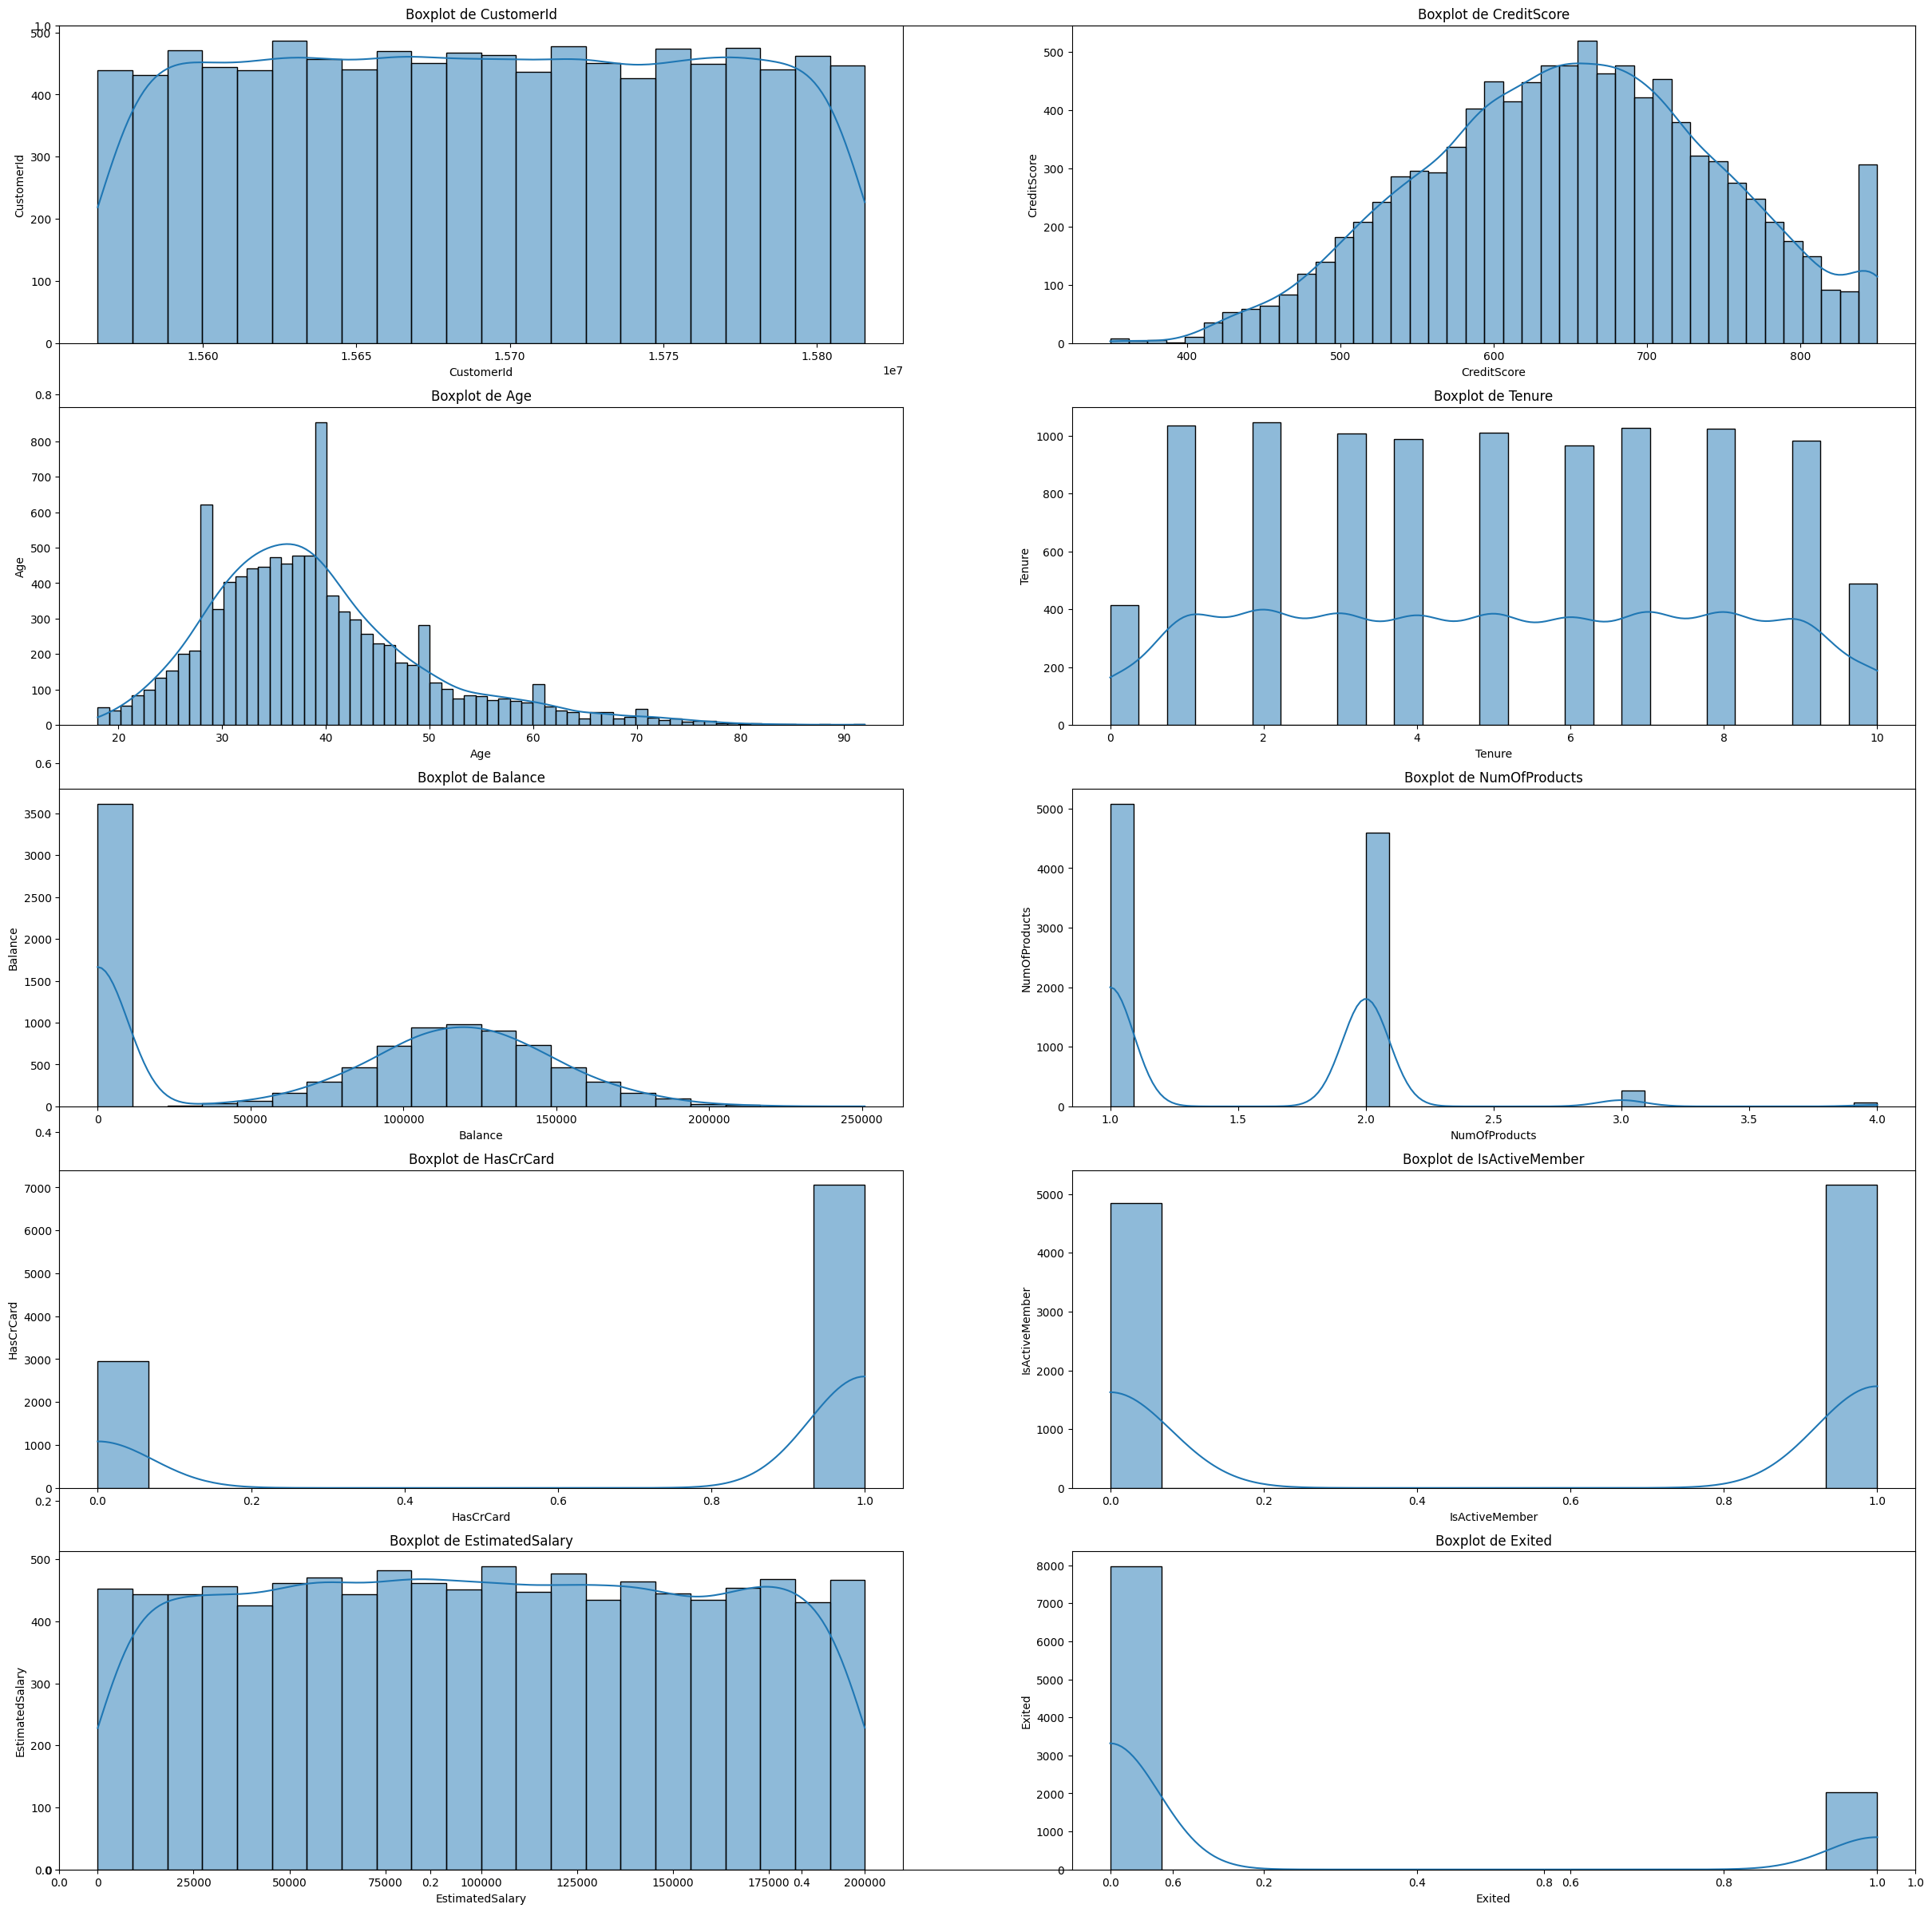

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt 

plt.subplots(figsize=(30,30))

for i, col in enumerate(numeric_cols[1:]) :
    p_df = df.select(col).toPandas()
    
    plt.subplot(5, 2, i+1)
    sns.histplot(p_df[col], edgecolor="black", kde=True)
    plt.title(f"Boxplot de {col}")
    plt.ylabel(col)

plt.show()

**Analyse des distributions des variables :**

| Colonne         | Médiane   | Moyenne   | Écart-type | Analyse de la distribution |
|----------------------|---------------|---------------|----------------|--------------------------------|
| CustomerId       | 15 690 738    | 15 690 940    | 71 936         | - Distribution Uniforme. <br>- Identifiant technique sans valeur explicative. |
| CreditScore      | 652           | 650.5         | 96.6           | - Distribution proche de la normale, centrée autour de 650. <br>- Peu d’outliers. |
| Age              | 37            | 38.9          | 10.5           | - Légère asymétrie à droite. <br>- Majorité entre 30–45 ans, présence de clients plus âgés. |
| Tenure           | 5             | 5.0           | 2.9            | - Répartition quasi uniforme entre 0 et 10 ans. |
| Balance          | 97.198        | 76.486        | 62.397         | - Fortement asymétrique à droite. <br>- Beaucoup de soldes nuls <br>- Quelques valeurs très élevées. |
| NumOfProducts    | 1             | 1.53          | 0.58           | - Discrète. <br>- Majorité avec 1 produit. <br>- Minorité avec 2. |
| HasCrCard        | 1             | 0.71          | 0.46           | - 71 % des clients ont une carte de crédit. <br>- Distribution déséquilibrée. |
| IsActiveMember   | 1             | 0.52          | 0.50           | - Variable binaire équilibrée. <br>- Presque 52 % de clients actifs. |
| EstimatedSalary  | 100.194       | 100.090       | 57.510         | - Distribution quasi uniforme. <br>- Utile pour segmenter par pouvoir d’achat. |
| Exited (Churn)   | 0             | 0.20          | 0.40           | - 20 % de churn. <br>- Dataset déséquilibré (80/20). |



##### **3.1. Analyser et Visualiser des Outliers avec Boxplot :**

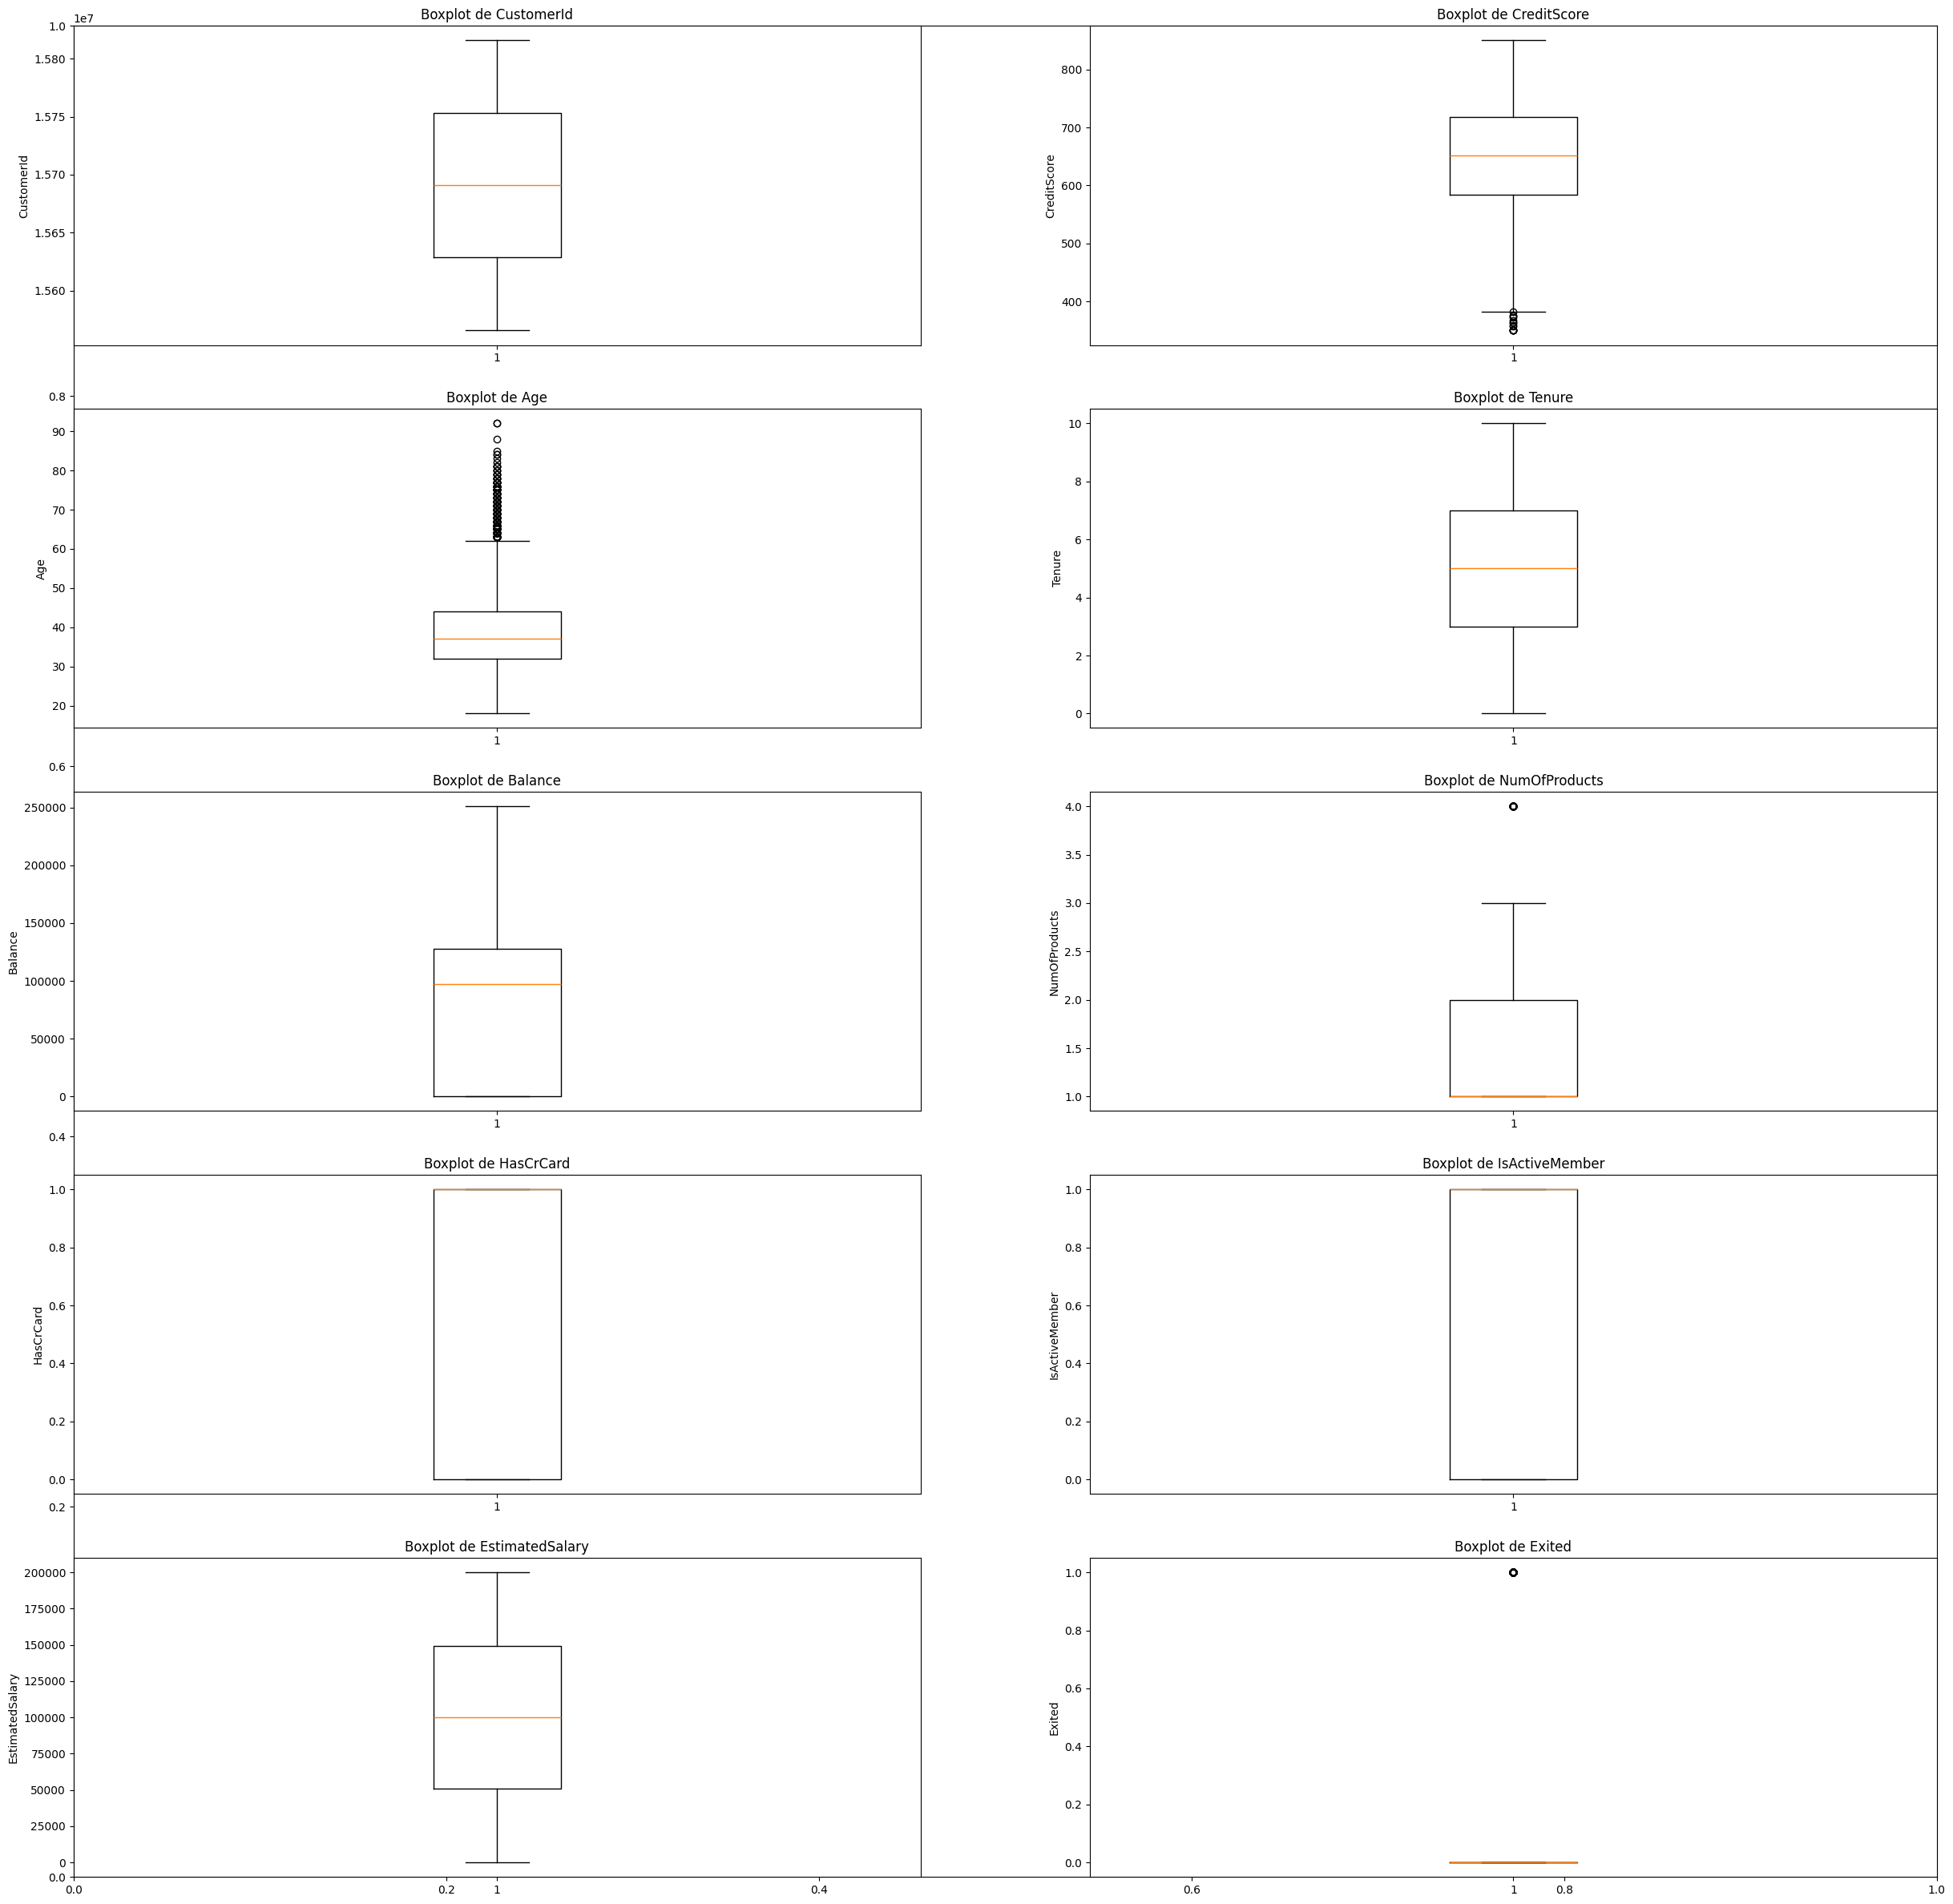

In [13]:
import matplotlib.pyplot as plt

plt.subplots(figsize=(30,30))

for i, col in enumerate(numeric_cols[1:]) :
    p_df = df.select(col).toPandas()

    plt.subplot(5, 2, i+1)
    plt.boxplot(p_df[col])
    plt.title(f"Boxplot de {col}")
    plt.ylabel(col)

plt.show()

**Analyse des Boxplots :**

| Variable          | Q1        | Q2 (Médiane) | Q3        | IQR       | Analyse |
|-----------------------|---------------|------------------|---------------|---------------|-------------|
| CustomerId        | 15 628 303    | 15 689 412       | 15 750 929    | 122 626       | - Identifiant unique, pas de valeur statistique utile. |
| CreditScore       | 584           | 651              | 714           | 130           | - Scores majoritairement moyens (584–714). <br>- Outliers possibles (<400 ou >800). |
| Age               | 32            | 37               | 44            | 12            | - Population jeune (32–44 ans). <br>- Outliers attendus (>60 ans). |
| Tenure            | 2             | 5                | 7             | 5             | - Ancienneté entre 2 et 7 ans. <br>- Distribution équilibrée. <br>- Pas d’outliers majeurs. |
| Balance           | 0             | 96 402           | 126 615       | 126 615       | - Forte dispersion. <br>- Beaucoup de clients avec solde nul, d’autres avec >120k. <br>- Distribution asymétrique. |
| NumOfProducts     | 1             | 1                | 2             | 1             | - La majorité a 1 ou 2 produits. <br>- Valeurs 3-4 rares (outliers). |
| HasCrCard         | 0             | 1                | 1             | 1             | - Variable binaire. <br>- La majorité possède une carte de crédit. |
| IsActiveMember    | 0             | 1                | 1             | 1             | - Variable binaire. <br>- La majorité est active. |
| EstimatedSalary   | 50 906        | 98 897           | 147 342       | 96 435        | - Distribution homogène autour de 100k. <br>- Outliers possibles (salaires très élevés). |
| Exited (cible)    | 0             | 0                | 0             | 0             | - Variable binaire déséquilibrée (majorité = 0). |




#### <span style="color:orange;">**4. Analyse groupée avec ``groupBy()`` et Agrégations :**</span>

##### **4.1. Compter le nombre total de clients pour chaque pays (Geography) :**

In [14]:
df_grouped = (
    df.groupBy("Geography")
      .agg(F.count("*").alias("Nombre_Clients"))
      .orderBy(F.desc("Nombre_Clients"))
)

df_grouped.show()

+---------+--------------+
|Geography|Nombre_Clients|
+---------+--------------+
|   France|          5014|
|  Germany|          2509|
|    Spain|          2477|
+---------+--------------+



##### **4.2. Calculer la moyenne du CreditScore pour chaque Geography :**

In [15]:
df_grouped = (
    df.groupBy("Geography")
      .agg(F.avg("CreditScore").alias("Avg_CreditScore"))
      .orderBy(F.desc("Avg_CreditScore"))
)

df_grouped.show()

+---------+-----------------+
|Geography|  Avg_CreditScore|
+---------+-----------------+
|  Germany|651.4535671582304|
|    Spain|651.3338716188938|
|   France|649.6683286796969|
+---------+-----------------+



##### **4.3. Calculer l’âge moyen (Age) selon le genre (Gender) :**

In [16]:
df_grouped = (
    df.groupBy("Gender")
      .agg(F.avg("Age").alias("avg_Age"))
      .orderBy(F.desc("avg_Age"))
)

df_grouped.show()

+------+------------------+
|Gender|           avg_Age|
+------+------------------+
|Female|39.238388729914156|
|  Male|38.658237126626354|
+------+------------------+



##### **4.4. Afficher la moyenne du Balance pour chaque combinaison (Geography, Gender) :**

In [17]:
df_grouped = (
    df.groupBy("Geography","Gender")
      .agg(F.avg("Balance").alias("avg_balance"))
      .orderBy(F.desc("avg_balance"))
)

df_grouped.show()

+---------+------+------------------+
|Geography|Gender|       avg_balance|
+---------+------+------------------+
|  Germany|  Male|120259.66822188442|
|  Germany|Female|119145.96647108134|
|   France|  Male| 63546.28487468217|
|    Spain|  Male|63352.833746397584|
|   France|Female|60322.670159221685|
|    Spain|Female| 59862.09253443531|
+---------+------+------------------+



##### **4.5. Calculer le pourcentage de clients sortants (Exited = 1) par pays (Geography) :**

In [18]:
df_grouped = (
    df.groupBy("Geography")
      .agg(
          (F.avg(F.col("Exited")) * 100).alias("percent_exited")
      )
      .orderBy(F.desc("percent_exited"))
)

df_grouped.show()

+---------+------------------+
|Geography|    percent_exited|
+---------+------------------+
|  Germany| 32.44320446392985|
|    Spain|16.673395236172787|
|   France| 16.15476665337056|
+---------+------------------+



##### **4.6. Regrouper les clients par tranches d’âge (ex. : 18–30, 31–40, 41-50, 51-60, >60) :**

In [19]:
df_grouped = df.withColumn(
    "tranche_age",
    F.when((df.Age >=18) & (df.Age <=30), "18-30")
     .when((df.Age >=31) & (df.Age <=40), "31-40")
     .when((df.Age >=41) & (df.Age <=50), "41-50")
     .when((df.Age >=51) & (df.Age <=60), "51-60")
     .otherwise(">60")
)

df_grouped.show()

+---------+----------+---------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+-----------+
|RowNumber|CustomerId|  Surname|CreditScore|Geography|Gender|Age|Tenure|  Balance|NumOfProducts|HasCrCard|IsActiveMember|EstimatedSalary|Exited|tranche_age|
+---------+----------+---------+-----------+---------+------+---+------+---------+-------------+---------+--------------+---------------+------+-----------+
|        1|  15634602| Hargrave|        619|   France|Female| 42|     2|      0.0|            1|        1|             1|      101348.88|     1|      41-50|
|        2|  15647311|     Hill|        608|    Spain|Female| 41|     1| 83807.86|            1|        0|             1|      112542.58|     0|      41-50|
|        3|  15619304|     Onio|        502|   France|Female| 42|     8| 159660.8|            3|        1|             0|      113931.57|     1|      41-50|
|        4|  15701354|     Boni|        699|   France|Fema

##### **4.7. Calculer la moyenne du EstimatedSalary par Tenure :**

In [20]:
df_grouped = (
    df.groupBy("Tenure")
      .agg(F.avg("EstimatedSalary").alias("avg_EstimatedSalary"))
      .orderBy("Tenure")
)

df_grouped.show()

+------+-------------------+
|Tenure|avg_EstimatedSalary|
+------+-------------------+
|     0| 102374.57912832928|
|     1| 100468.61895652162|
|     2|  98312.35985687024|
|     3|  97667.19628344904|
|     4|  99867.77782608703|
|     5| 101286.00964426876|
|     6|  99168.73315408481|
|     7| 101257.24036964984|
|     8| 101072.10293658532|
|     9|  99416.70702235772|
|    10| 102805.90922448985|
+------+-------------------+



##### **4.8. Compter le nombre de clients pour chaque valeur de NumOfProducts :**

In [21]:
df_grouped = (
    df.groupBy("NumOfProducts")
      .agg(F.count("*").alias("nb_clients"))
      .orderBy("NumOfProducts")
)

df_grouped.show()

+-------------+----------+
|NumOfProducts|nb_clients|
+-------------+----------+
|            1|      5084|
|            2|      4590|
|            3|       266|
|            4|        60|
+-------------+----------+



##### **4.9. Calculer le pourcentage de IsActiveMember = 1 pour chaque NumOfProducts :**

In [22]:
df_grouped = (
    df.groupBy("NumOfProducts")
      .agg((F.avg(F.col("IsActiveMember")) * 100).alias("percent_IsActiveMember"))
      .orderBy(F.desc("percent_IsActiveMember"))
)

df_grouped.show()

+-------------+----------------------+
|NumOfProducts|percent_IsActiveMember|
+-------------+----------------------+
|            2|     53.28976034858388|
|            1|    50.413060582218726|
|            4|    48.333333333333336|
|            3|      42.4812030075188|
+-------------+----------------------+



##### **4.10. Calculer la moyenne du Balance selon Exited (0 ou 1) :**

In [23]:
df_grouped = (
    df.groupBy("Exited")
      .agg(F.avg("Balance").alias("avg_balance"))
      .orderBy(F.desc("avg_balance"))
)

df_grouped.show()

+------+-----------------+
|Exited|      avg_balance|
+------+-----------------+
|     1|91108.53933726063|
|     0|72745.29677885193|
+------+-----------------+



**11.** Calculer la moyenne du CreditScore selon HasCrCard (0 ou 1).

**12.** Calculer la moyenne et l’écart-type de EstimatedSalary pour chaque IsActiveMember.

**13.** Calculer la moyenne du Tenure par pays (Geography).

**14.** Calculer le pourcentage de clients Exited = 1 par Gender.

**15.** Calculer la moyenne de Age selon IsActiveMember.

**16.** Calculer la moyenne de CreditScore par NumOfProducts.

**17.** Faire la somme (SUM) du Balance pour chaque Geography.

**18.** Calculer la moyenne du EstimatedSalary pour les clients Exited = 1, regroupés par Gender.

**19.** Calculer le taux de Exited = 1 pour chaque combinaison de Geography et Gender.

**20.** Calculer la moyenne du CreditScore par Tenure.